# Explanation    
Let's see how we can deploy out model and it's explnation at the same time.    
This means we want to predict with model, and the explanation for the prediction.

We start by building feature engineering and training a model.

In [1]:
import vaex
import warnings
from vaex.ml.datasets import load_iris
from vaex.ml.lightgbm import LightGBMModel
from goldilox import Pipeline
import numpy as np
import json

warnings.filterwarnings('ignore')


df = load_iris()
target = 'class_'

# feature engineering example
df['petal_ratio'] = df['petal_length'] / df['petal_width'] 
features = ['petal_length', 'petal_width', 'sepal_length', 'sepal_width', 'petal_ratio']
booster = LightGBMModel(features=features,
                        target=target,
                        prediction_name='predictions',
                        num_boost_round=500, params={'verbosity': -1,
                                                     'objective': 'multiclass',
                                                     'num_class': 3})
booster.fit(df)
df = booster.transform(df)

# post model processing example
@vaex.register_function()
def argmax(ar, axis=1):
    return np.argmax(ar, axis=axis)
df.add_function('argmax', argmax)
df['prediction'] = df['predictions'].argmax()

df['label'] = df['prediction'].map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})

# Vaex remember all the transformations, this is a skleran.pipeline alternative
pipeline = Pipeline.from_vaex(df, description='simple lightGBM')
pipeline.raw.pop(target) # (optional) we don't expect to get the class_ in queries
assert pipeline.validate()
print("Pipeline raw data example:")
print(json.dumps(pipeline.raw, indent=4))
print('')
print("Pipeline output example:")
pipeline.inference(pipeline.raw).to_records()
df.head(2)

Pipeline raw data example:
{
    "sepal_length": 5.9,
    "sepal_width": 3.0,
    "petal_length": 4.2,
    "petal_width": 1.5
}

Pipeline output example:


#,sepal_length,sepal_width,petal_length,petal_width,class_,petal_ratio,predictions,prediction,label
0,5.9,3,4.2,1.5,1,2.8,"'array([2.50134389e-08, 9.99999969e-01, 6.259919...",1,versicolor
1,6.1,3,4.6,1.4,1,3.28571,"'array([8.83971014e-07, 9.99999089e-01, 2.725598...",1,versicolor


Let's add a column which show per prediction the effect of the features. 

In [15]:
import shap
import pyarrow as pa
import pandas as pd

explainer = shap.TreeExplainer(booster.booster)
targets = df['class_'].unique()
feature_count = len(features)

@vaex.register_function(on_expression=False)
def explain(*columns):    
    data = np.array(columns).T
    X = pd.DataFrame(data[:,:feature_count], columns=features)    
    y = data[:,-1]
    shap_values = explainer.shap_values(X)
    explanation = []
    
    for i, c in enumerate(y):
        c = int(c)
        e = shap.force_plot(explainer.expected_value[c], shap_values[c][i,:], X.iloc[i]).data
        explanation.append({feature:effects['effect'] for feature, effects in zip(e['featureNames'], e['features'].values())})
    return pa.array(explanation)
    
df.add_function('explain', explain)
explain_columns = features+['prediction']
df['explanation']  =df.func.explain(*explain_columns)

# get ready for production
pipeline = Pipeline.from_vaex(df)
pipeline.validate()
pipeline.inference(pipeline.raw)


#,sepal_length,sepal_width,petal_length,petal_width,class_,petal_ratio,predictions,prediction,label,explanation
0,5.9,3,4.2,1.5,1,2.8,"'array([2.50134389e-08, 9.99999969e-01, 6.259919...",1,versicolor,"""{'petal_length': 3.5222047977554025, 'petal_rat..."


Let's save the global model features explnation as a picture, this will allow us to provide it in the */varaibles* endpoint for the frontend.

In [13]:
import matplotlib.pyplot as plt
from tempfile import TemporaryDirectory

path = TemporaryDirectory().name+'image.jpg'
X = df[features].to_pandas_df()
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, feature_names=features, show=False)
plt.savefig(path)
plt.close()

with open(path, 'rb') as f:
    imagebytes = f.read()
_ = pipeline.set_variable('image', imagebytes)

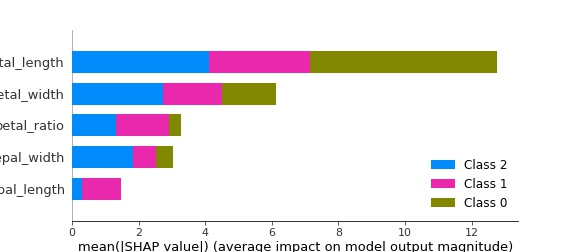

In [14]:
# Check the image
from IPython.display import Image

path = TemporaryDirectory().name+'image.jpg'
with open(path, 'wb') as f:
    f.write(pipeline.variables['image'])

Image(filename=path) 


# Serve

In [ ]:
print(f"Saved to: {pipeline.save("pipeline.pkl"))
print(f"Check out the docs: http://127.0.0.1:5000/docs\n")

!gl serve pipeline.pkl